# 1.c Utilisation de modèles temporelles sur les données simples
Dans un second temps, après avoir essayer les algorithmes de Machine Learning classique, nous allons observer les résultats pour des modèles dédiés aux séries temporelles.

In [89]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly

In [2]:
data_convention = pd.read_csv('../data/comptages-routiers-permanents-convention.csv', sep=";")
data_champs = pd.read_csv('../data/comptages-routiers-permanents-champs.csv', sep=";")
data_peres = pd.read_csv('../data/comptages-routiers-permanents-peres.csv', sep=";")

In [77]:
def prepare_time_series(df: pd.DataFrame, time_column:str, target_column:str):
    temp = pd.DataFrame()
    temp["ds"] = pd.to_datetime(df[time_column], utc=True).dt.tz_convert("Europe/Paris")
    temp["ds"] = pd.to_datetime(temp["ds"].dt.strftime('%Y-%m-%d %H:%M:%S'))
    temp["y"] = np.log(df[target_column])
    temp = temp.sort_values("ds")
    temp = temp.reset_index(drop=True)
    return temp

In [126]:
ts_convention_occupation = prepare_time_series(data_convention, "Date et heure de comptage", "Taux d'occupation")
ts_champs_occupation = prepare_time_series(data_champs, "Date et heure de comptage", "Taux d'occupation")
ts_peres_occupation = prepare_time_series(data_peres, "Date et heure de comptage", "Taux d'occupation")
ts_convention_debit = prepare_time_series(data_convention, "Date et heure de comptage", "Débit horaire")
ts_champs_debit = prepare_time_series(data_champs, "Date et heure de comptage", "Débit horaire")
ts_peres_debit = prepare_time_series(data_peres, "Date et heure de comptage", "Débit horaire")

<AxesSubplot:>

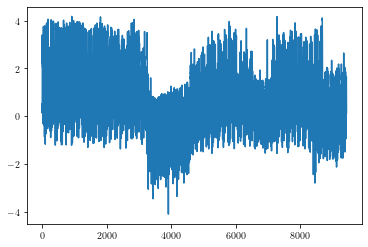

In [79]:
ts_convention_occupation["y"].plot()

In [119]:
premier_confinement = pd.DataFrame({
    "holiday":"premier_confinement",
    "ds": pd.date_range("2020-03-17", "2020-05-10"),
    "lower_window": 0,
    "upper_window": 20
})
couvre_feu = pd.DataFrame({
    "holiday":"couvre_feu",
    "ds": pd.date_range("2020-10-17", "2020-10-30"),
    "lower_window": 0,
    "upper_window": 1
})
deuxieme_confinement_part1 = pd.DataFrame({
    "holiday":"deuxieme_confinement_part1",
    "ds": pd.date_range("2020-10-30", "2020-11-27"),
    "lower_window": 0,
    "upper_window": 1
})
deuxieme_confinement_part2 = pd.DataFrame({
    "holiday":"deuxieme_confinement_part2",
    "ds": pd.date_range("2020-11-28", "2020-12-14"),
    "lower_window": 0,
    "upper_window": 1
})
covid_restrictions = pd.concat((premier_confinement, couvre_feu, deuxieme_confinement_part1, deuxieme_confinement_part2))
covid_restrictions.head()

holiday         ds  lower_window  upper_window
0  premier_confinement 2020-03-17             0            20
1  premier_confinement 2020-03-18             0            20
2  premier_confinement 2020-03-19             0            20
3  premier_confinement 2020-03-20             0            20
4  premier_confinement 2020-03-21             0            20

In [120]:
m_convention_occupation = Prophet(holidays=covid_restrictions, )
m_convention_occupation.add_country_holidays("FRA")
m_convention_occupation.fit(ts_convention_occupation)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [121]:
future = m_convention_occupation.make_future_dataframe(periods=24*14, freq="H")
future

ds
0    2019-11-01 04:00:00
1    2019-11-01 05:00:00
2    2019-11-01 06:00:00
3    2019-11-01 07:00:00
4    2019-11-01 08:00:00
...                  ...
9762 2020-12-13 20:00:00
9763 2020-12-13 21:00:00
9764 2020-12-13 22:00:00
9765 2020-12-13 23:00:00
9766 2020-12-14 00:00:00

[9767 rows x 1 columns]

In [122]:
forecast = m_convention_occupation.predict(future)

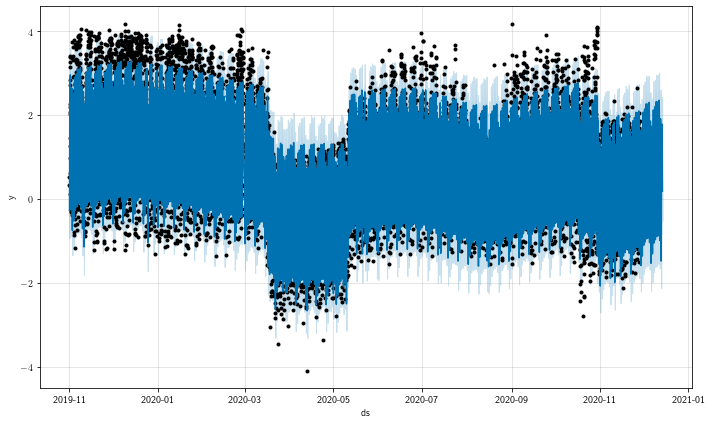

In [123]:
fig1 = m_convention_occupation.plot(forecast)

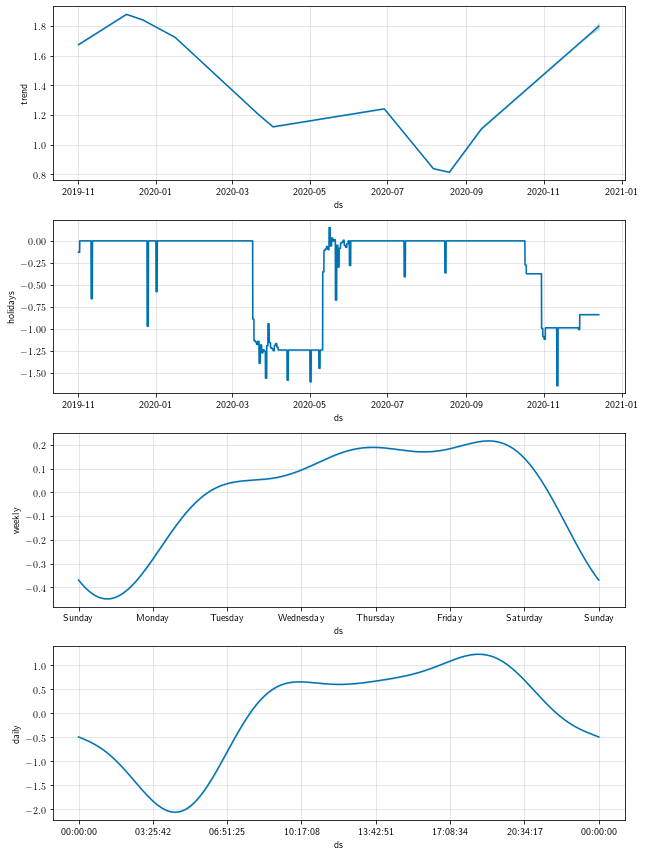

In [124]:
fig2 = m_convention_occupation.plot_components(forecast)

In [125]:
plot_components_plotly(m_convention_occupation, forecast)